In [1]:
import os, glob
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2, ttest_ind
from scipy.ndimage import maximum_filter, label, find_objects

from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from sklearn.decomposition import PCA
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
from skimage.exposure import adjust_gamma
import imageio
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


## Define functions
### Anisotropy measurement

In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


# Function to compute turning metrics
def compute_eigen_directionality(x, y):
    """
    Compute the eigen decomposition of the covariance matrix of the shifted (x, y) trajectory.
    Returns the principal axis orientation and anisotropy ratio.
    """
    x_shifted = x - x[0]
    y_shifted = y - y[0]

    cov_matrix = np.cov(np.vstack((x_shifted, y_shifted)))
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    lambda_1, lambda_2 = eigenvalues[sorted_indices]
    v1 = eigenvectors[:, sorted_indices[0]]  # Principal axis direction

    anisotropy_ratio = lambda_2 / lambda_1
    principal_angle = np.arctan2(v1[1], v1[0])

    return principal_angle, anisotropy_ratio

# Function to analyze trajectory orientation and compute turning metrics
def analyze_trajectory_orientation(df):
    """
    Analyzes the dominant movement direction of trajectories by applying PCA 
    and computes final direction distributions.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'particle', 'x', and 'y' columns.

    Returns:
        pd.DataFrame: DataFrame containing turning angles and anisotropy ratios.
    """
    turning_metrics = []

    # Iterate over each particle's trajectory
    for particle, group in df.groupby("particle"):
        x, y = group["x"].values, group["y"].values
        x_shifted = x - x[0]
        y_shifted = y - y[0]

        # Apply PCA to each trajectory (individual PCA per trajectory)
        pca = PCA(n_components=2)
        pca.fit(np.column_stack((x_shifted, y_shifted)))
        
        # Compute the angle of the final displacement vector
        angle = np.arctan2(y_shifted[-1], x_shifted[-1])

        # Calculate the anisotropy ratio (lambda_2 / lambda_1) for each trajectory
        anisotropy_ratio = pca.explained_variance_ratio_[1] / pca.explained_variance_ratio_[0]

        # Store results
        turning_metrics.append({"particle": particle, "turning_angle": angle, "anisotropy_ratio": anisotropy_ratio})

    return pd.DataFrame(turning_metrics)

# Function to load trajectories and compute turning metrics
def load_and_compute_turning_metrics(paths):
    dfs = []
    for path in paths:
        csv_path = os.path.join(path, 'tp_trajectories_final.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            if {'particle', 'x', 'y'}.issubset(df.columns):  # Ensure required columns exist
                metrics_df = analyze_trajectory_orientation(df)
                metrics_df['file_address'] = path  # Store the folder path
                dfs.append(metrics_df.set_index('file_address'))
    
    return pd.concat(dfs, axis=0) if dfs else pd.DataFrame()

In [3]:
def wasserstein_distance(u_samples, v_samples, p=1):
    """
    Computes the 1-Wasserstein or 2-Wasserstein distance between two discrete probability measures.

    Parameters:
    u_samples (array-like): Sample vector for the first distribution.
    v_samples (array-like): Sample vector for the second distribution.
    p (int, optional): Order of the Wasserstein distance. Must be either 1 or 2. Default is 1.

    Returns:
    float: The p-Wasserstein distance between the distributions.
    """
    u_samples_sorted = np.sort(np.asarray(u_samples))
    v_samples_sorted = np.sort(np.asarray(v_samples))
    
    if p == 1:
        all_samples = np.unique(np.concatenate([u_samples_sorted, v_samples_sorted]))
        
        u_cdf = np.searchsorted(u_samples_sorted, all_samples, side='right') / len(u_samples_sorted)
        v_cdf = np.searchsorted(v_samples_sorted, all_samples, side='right') / len(v_samples_sorted)

        return np.sum(np.abs(u_cdf[:-1] - v_cdf[:-1]) * np.diff(all_samples))
    
    elif p == 2:
        u_N = len(u_samples_sorted)
        v_N = len(v_samples_sorted)
        
        all_prob = np.unique(np.concatenate([(np.arange(u_N + 1) / u_N), (np.arange(v_N + 1) / v_N)]))

        u_icdf = np.interp(all_prob[:-1], np.arange(u_N) / u_N, u_samples_sorted)
        v_icdf = np.interp(all_prob[:-1], np.arange(v_N) / v_N, v_samples_sorted)

        return np.sqrt(np.sum((u_icdf - v_icdf) ** 2 * np.diff(all_prob)))
    
    else:
        raise ValueError("Only p=1 or p=2 allowed.")


### Burstiness measurement

In [4]:
def calculate_cv_for_first_appearances(df, num_frames, window_size=10):
    """
    This function calculates the Coefficient of Variation (CV) for particle appearance trajectories.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the trajectory data.
    num_frames (int): The total number of frames.
    window_size (int): The window size for calculating overall CV, default is 10.
    
    Returns:
    float: The Coefficient of Variation (CV).
    """
    # 4. Calculate burstiness metrics (autocorrelation and CV for first appearances)
    first_appearances = df.groupby('particle')['frame'].min()
    first_appearance_counts = first_appearances.value_counts().sort_index()

    # Ensure all frames are represented, even those with no first appearance
    all_frames = np.arange(0, num_frames)
    first_appearance_counts_full = pd.Series(0, index=all_frames)
    first_appearance_counts_full.update(first_appearance_counts)

    trajectory_counts_per_frame = first_appearance_counts_full.values

    # Coefficient of Variation (CV) for first appearance counts
    mean_first_appearances = first_appearance_counts_full.mean()
    std_first_appearances = first_appearance_counts_full.std()
    
    if mean_first_appearances != 0:
        cv_first_appearances = std_first_appearances / mean_first_appearances
    else:
        cv_first_appearances = np.nan

    # 5. Calculate the overall Coefficient of Variation (CV) based on counts in windows
    sum_counts = []
    # Create a list to store the counts in each window
    counts_in_windows = []
    for start in range(0, len(trajectory_counts_per_frame), window_size):
        end = min(start + window_size, len(trajectory_counts_per_frame))
        counts_in_windows.append(trajectory_counts_per_frame[start:end])

    for i in range(len(counts_in_windows)):
        sum_counts.append(sum(counts_in_windows[i]))

    # Calculate the overall CV
    overall_cv = np.std(sum_counts) / np.mean(sum_counts)

    return overall_cv



def load_and_compute_cv(paths):
    """
    Load trajectory data and compute the Coefficient of Variation (CV) for first particle appearances.
    
    Parameters:
    paths (list): List of directory paths containing CSV files with particle trajectories.
    
    Returns:
    pd.DataFrame: A DataFrame containing the CV values for each movie (file address).
    """
    cv_results = []  # List to store CV results for each movie
    
    for path in paths:
        csv_path = os.path.join(path, 'tp_trajectories_final.csv')
        
        if os.path.exists(csv_path):
            # Load the CSV into a DataFrame
            df = pd.read_csv(csv_path)
            
            # Check if required columns are present
            if {'particle', 'frame'}.issubset(df.columns):
                # Search for the .tiff file to get the number of frames
                tiff_files = glob.glob(os.path.join(path, '*_jttr_blch_corr.tiff'))
                if tiff_files:
                    tiff_file_path = tiff_files[0]
                    with tiff.TiffFile(tiff_file_path) as tif:
                        num_frames = len(tif.pages)
                    # print(f"Number of frames in the tiff file: {num_frames}")
                else:
                    print("No '_jttr_blch_corr.tiff' file found in the folder.")
                    continue

                # Calculate the CV for the current movie
                cv_value = calculate_cv_for_first_appearances(df, num_frames)
                
                # Store the result with the corresponding file address (folder path)
                cv_results.append({'file_address': path, 'CV': cv_value})
    
    # Convert the list of results into a DataFrame
    cv_df = pd.DataFrame(cv_results)
    
    # Set the 'file_address' as the index (optional)
    cv_df.set_index('file_address', inplace=True)
    
    return cv_df


## All flat movies

In [5]:
## DIV2
div2_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min')
div2_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse2_2secPerTP_5min')
div2_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse3_2secPerTP_10min')
div2_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1')
div2_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_A1_timelapse1')
div2_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_A1_timelapse2')
div2_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse1')


## DIV3
div3_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse1')
div3_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse2')
div3_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse3')
div3_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse4')
div3_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_03_24_div3_corticalNeurons_timelapse1_preEfield_5min')


## DIV5
div5_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_07_20_MAX_A1_40x_timelapse2 (2 sec per T)')
div5_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_07_20_MAX_A3_40x_timelapse2 (2 sec per T)')
div5_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1')
div5_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse3')
div5_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse2')


## DIV7
div7_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_A1_24h on DIV3_488_timelapse2')
div7_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_B1_48h on DIV3_488_timelapse3')
div7_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_C1_24h on DIV6_488_timelapse6')
div7_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_10_01_MAX_40x_CX6well_+PDL+LAMglass_Movie2')
div7_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFPonly_DIV7_timelapse')
div7_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C1_glass+PDL_timelapse1')
div7_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse1')
div7_addr8 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2')
div7_addr9 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFP_RFP 2.5_2.5 DIV7 488_561 timelapse3_C1')
div7_addr10 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFP_RFP 5_5 DIV7 488_561 timelapse1_C1')
div7_addr11 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_06_24_cortical_div7_timelapse_2')
div7_addr12 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2021_12_06_div7neurons_dish1_15mm_40x_neuron2_media')
div7_addr13 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2021_12_06_div7neurons_dish1_15mm_40x_neuron1_media')


## DIV10
div10_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2019_04_22_NewPdl_GFP RFP_5 5_488_timelapse1')
div10_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron1_media')
div10_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron2_media')
div10_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron3_media')
div10_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron4_media')
div10_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron5_media')

## DIV11

div11_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div11\control_2019_02_11_CL+DIV7_Cort_timelapse5')

## DIV12
div12_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div12\control_2018_08_24_MAX_Cx_40x_B1+CLonDIV3_timelapse1')

## DIV14
div14_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div14\control_2019_02_11_Cort_DIV3_top_timelapse1')
div14_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div14\control_2019_02_11_plate1_timelapse1')

## DIV16
div16_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+DIV10_timelapse1')
div16_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV10_timelapse1')
div16_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV10_timelapse2_2')
div16_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse2')
div16_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+DIV6_timelapse2_2')
div16_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse1')

## DIV17
div17_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse2')
div17_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse4')
div17_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate2_timelapse1')
div17_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse3')

## DIV21
div21_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_02_11_Coth_+CLDIV14_timelapse')
div21_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_04_22_Cort_DIV21_+CLDIV17_NewPDL_timelapse2a')
div21_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_04_22_Cort_DIV21_+CLDIV17_NewPDL_timelapse2b')


## DIV23
div23_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1')
div23_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b')


## Combining all the .csv files into three stages: early, middle and late
### Calculating the curvature metrics

In [6]:
# Define the paths for each DIV group
div2_paths = [div2_addr1, div2_addr2, div2_addr3, div2_addr4, div2_addr5, div2_addr6, div2_addr7]
div3_paths = [div3_addr1, div3_addr2, div3_addr3, div3_addr4, div3_addr5]
div5_paths = [div5_addr1, div5_addr2, div5_addr3, div5_addr4, div5_addr5]

div7_paths = [div7_addr1, div7_addr2, div7_addr3, div7_addr4, div7_addr5, div7_addr6, div7_addr7, div7_addr8, div7_addr9, div7_addr10, div7_addr11, div7_addr12, div7_addr13]
div10_paths = [div10_addr1, div10_addr2, div10_addr3, div10_addr4, div10_addr5, div10_addr6]
div11_paths = [div11_addr1]
div12_paths = [div12_addr1]

div14_paths = [div14_addr1, div14_addr2]
div16_paths = [div16_addr1, div16_addr2, div16_addr3, div16_addr4, div16_addr5, div16_addr6]
div17_paths = [div17_addr1, div17_addr2, div17_addr3, div17_addr4]
div21_paths = [div21_addr1, div21_addr2, div21_addr3]
div23_paths = [div23_addr1, div23_addr2]


# Load each stage and compute turning metrics
early_stage = load_and_compute_turning_metrics(div2_paths + div3_paths + div5_paths)
middle_stage = load_and_compute_turning_metrics(div7_paths + div10_paths + div11_paths + div12_paths)
late_stage = load_and_compute_turning_metrics(div14_paths + div16_paths + div17_paths + div21_paths + div23_paths)

# Load each stage and compute Coefficient of Variation (CV) for first particle appearances
early_stage_cv = load_and_compute_cv(div2_paths + div3_paths + div5_paths)
middle_stage_cv = load_and_compute_cv(div7_paths + div10_paths + div11_paths + div12_paths)
late_stage_cv = load_and_compute_cv(div14_paths + div16_paths + div17_paths + div21_paths + div23_paths)

# Concatenate along a new axis with MultiIndex
early_stage_merged = pd.concat({'early_stage': early_stage}, axis=0)
middle_stage_merged = pd.concat({'middle_stage': middle_stage}, axis=0)
late_stage_merged = pd.concat({'late_stage': late_stage}, axis=0)

# Concatenate CV results
early_stage_cv_merged = pd.concat({'early_stage_cv': early_stage_cv}, axis=0)
middle_stage_cv_merged = pd.concat({'middle_stage_cv': middle_stage_cv}, axis=0)
late_stage_cv_merged = pd.concat({'late_stage_cv': late_stage_cv}, axis=0)

# Define output folder
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames')

# Save the merged DataFrames as CSV files with indexing
early_stage_merged.to_csv(data_folder + '\\early_stage_turning_metrics.csv', index=True)
middle_stage_merged.to_csv(data_folder + '\\middle_stage_turning_metrics.csv', index=True)
late_stage_merged.to_csv(data_folder + '\\late_stage_turning_metrics.csv', index=True)

# Save CV results as CSV files
early_stage_cv_merged.to_csv(data_folder + '\\early_stage_cv.csv', index=True)
middle_stage_cv_merged.to_csv(data_folder + '\\middle_stage_cv.csv', index=True)
late_stage_cv_merged.to_csv(data_folder + '\\late_stage_cv.csv', index=True)

print("Turning metrics saved as 'early_stage_turning_metrics.csv', 'middle_stage_turning_metrics.csv', and 'late_stage_turning_metrics.csv'")
print("CV results saved as 'early_stage_cv.csv', 'middle_stage_cv.csv', 'late_stage_cv.csv'")


Turning metrics saved as 'early_stage_turning_metrics.csv', 'middle_stage_turning_metrics.csv', and 'late_stage_turning_metrics.csv'
CV results saved as 'early_stage_cv.csv', 'middle_stage_cv.csv', 'late_stage_cv.csv'


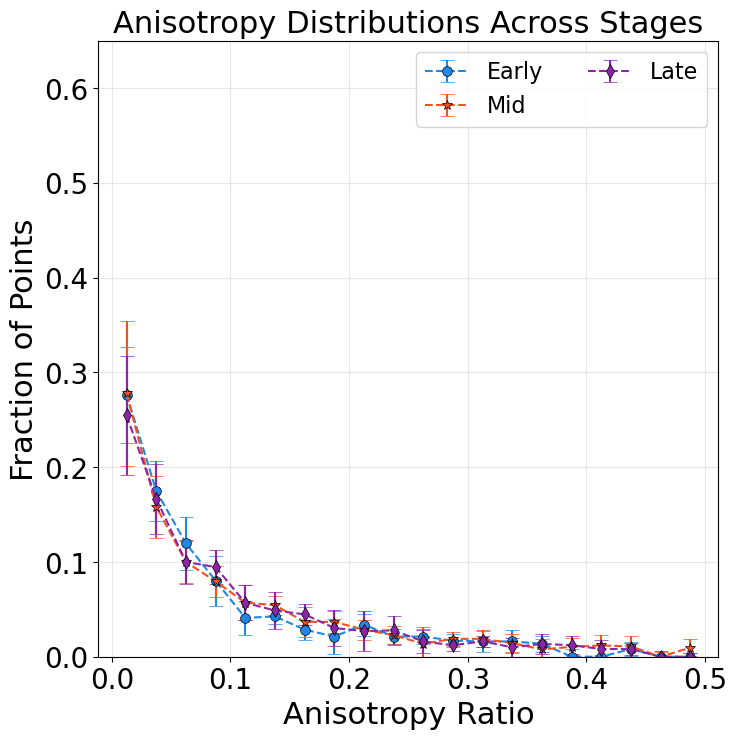

In [6]:
def plot_combined_anisotropy_distributions(stage_files, stage_labels, num_bins=20):
    """
    Plots the anisotropy distribution with error bars (0.5 * IQR) 
    for multiple stages on the same plot, with bins constrained to [0, 0.5].

    Parameters:
        stage_files (list of str): List of CSV file paths, one per stage.
        stage_labels (list of str): Labels for the stages.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 8))

    # Define colors, markers, and dataset labels
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']  # Colors for Early, Middle, Late stages
    marker_labels = ["o", "*", "d"]  # Markers for Early, Middle, Late stages

    # Define fixed bin edges between 0 and 0.5
    bin_edges = np.linspace(0, 0.5, num_bins + 1)

    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        # Load anisotropy data
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        # List to store histograms (raw counts)
        histograms = []

        # Group by 'file_address'
        for _, group in df.groupby('file_address'):
            # Extract anisotropy values and remove NaNs
            anisotropy_values = group['anisotropy_ratio'].dropna().values

            # Calculate the histogram (raw counts, no density)
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)  # Raw counts histogram

            # Calculate fraction by dividing by the total number of points
            hist_fraction = hist / hist.sum()  # Fraction for each bin
            histograms.append(hist_fraction)

        # Convert histograms to a NumPy array for further processing
        histograms = np.array(histograms)  # Shape will be (num_movies, num_bins)

        # Compute median and 0.5 * IQR for each bin
        median_hist = np.median(histograms, axis=0)
        iqr_hist = np.percentile(histograms, 75, axis=0) - np.percentile(histograms, 25, axis=0)
        error_bars = 0.5 * iqr_hist

        # Compute bin centers for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot with dashed lines and error bars
        plt.errorbar(bin_centers, median_hist, yerr=error_bars, fmt=marker_labels[i], color=color_labels[i], 
                     capsize=5, linestyle='--', label=label, markeredgecolor='black', 
                     markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)

    # Labels and formatting
    plt.xlabel("Anisotropy Ratio", fontsize=22)
    plt.ylabel("Fraction of Points", fontsize=22)
    plt.ylim([0,0.65])
    plt.title("Anisotropy Distributions Across Stages", fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=16, ncol=2)
    plt.grid(alpha=0.3)

    # plt.savefig(data_folder+'\\flat_orientation_of_tracks.svg', format='svg', bbox_inches='tight')
    plt.show()
    
# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_turning_metrics.csv"
]
stage_labels = ["Early", "Mid", "Late"]

data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames')
plot_combined_anisotropy_distributions(stage_files, stage_labels)


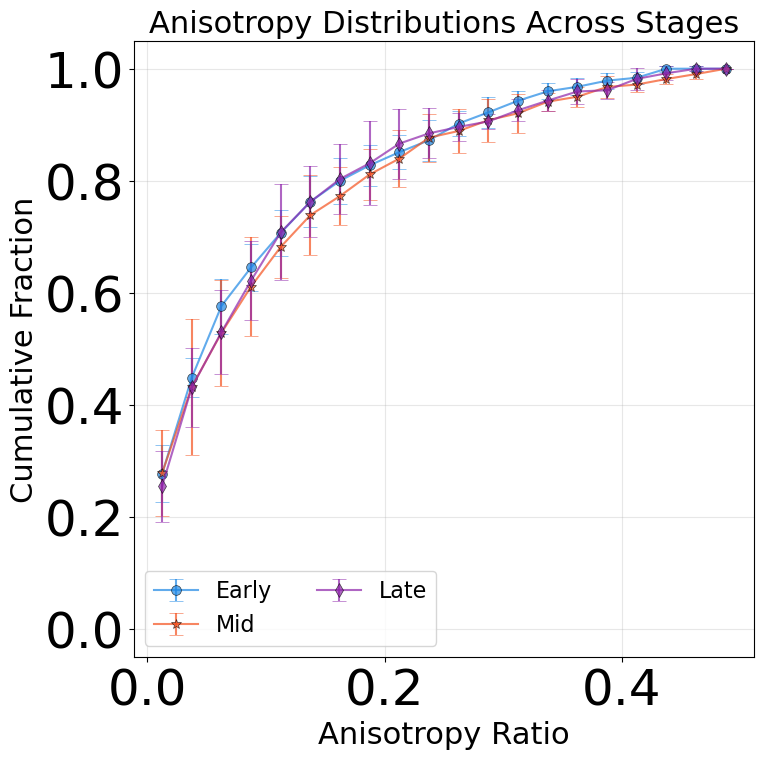

In [138]:
def plot_anisotropy_distributions(stage_files, stage_labels, num_bins=20):
    """
    Plots the anisotropy distribution with error bars (0.5 * IQR) 
    and the cumulative distribution for multiple stages on the same plot.
    """
    plt.figure(figsize=(8, 8))

    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']  # Colors for Early, Middle, Late stages
    marker_labels = ["o", "*", "d"]  # Markers for Early, Middle, Late stages

    bin_edges = np.linspace(0, 0.5, num_bins + 1)

    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        df = pd.read_csv(file_path)
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        histograms = []
        cumulative_histograms = []

        for _, group in df.groupby('file_address'):
            anisotropy_values = group['anisotropy_ratio'].dropna().values
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)
            hist_fraction = hist / hist.sum()
            histograms.append(hist_fraction)
            cumulative_histograms.append(np.cumsum(hist_fraction))

        histograms = np.array(histograms)
        cumulative_histograms = np.array(cumulative_histograms)

        median_cdf = np.median(cumulative_histograms, axis=0)
        iqr_cdf = np.percentile(cumulative_histograms, 75, axis=0) - np.percentile(cumulative_histograms, 25, axis=0)
        error_cdf = 0.5 * iqr_cdf

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        
        plt.errorbar(bin_centers, median_cdf, yerr=error_cdf, fmt=marker_labels[i], color=color_labels[i],
                     capsize=5, linestyle='-', label=f"{label}", markeredgecolor='black',
                     markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=0.7)
    
    plt.xlabel("Anisotropy Ratio", fontsize=22)
    plt.ylabel("Cumulative Fraction", fontsize=22)
    plt.title("Anisotropy Distributions Across Stages", fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=36)
    plt.tick_params(axis='both', which='minor', labelsize=36)
    plt.legend(fontsize=16, ncol=2)
    plt.ylim([-0.05,1.05])
    plt.grid(alpha=0.3)
    plt.savefig(data_folder+'\\flat_orientation_of_tracks_cumulative.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_turning_metrics.csv"
]
stage_labels = ["Early", "Mid", "Late"]

plot_anisotropy_distributions(stage_files, stage_labels)


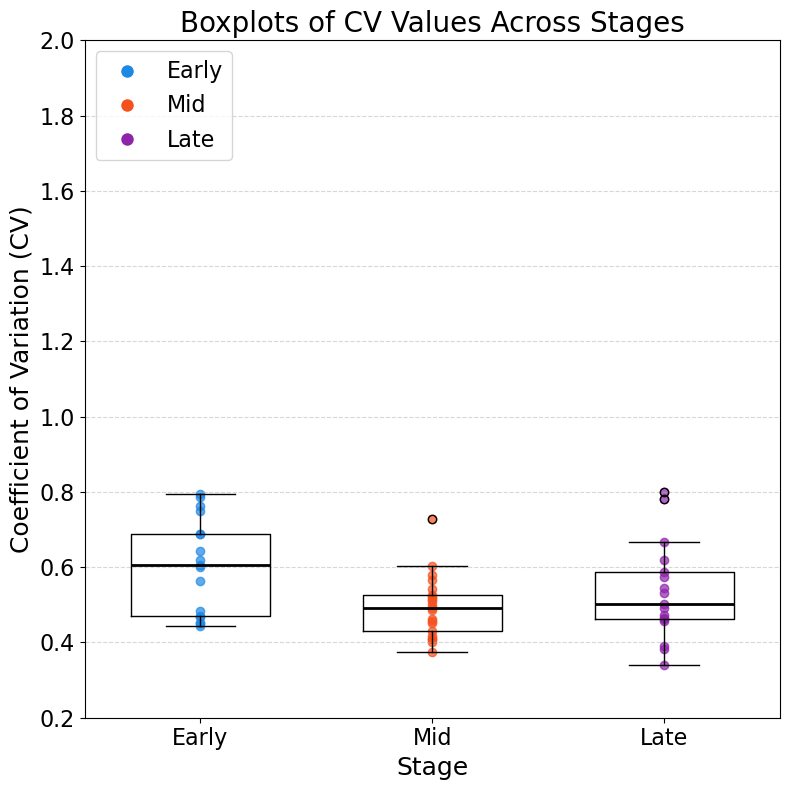

In [192]:
def plot_cv_boxplots(stage_files, stage_labels):
    """
    Plots boxplots for the Coefficient of Variation (CV) values for multiple stages,
    with scatter points for each CV value.
    
    Parameters:
        stage_files (list of str): List of CSV file paths, one per stage.
        stage_labels (list of str): Labels for the stages.
    """
    # Prepare data for plotting boxplots
    cv_values = []

    for file_path in stage_files:
        # Load the CV data for the stage
        df = pd.read_csv(file_path)
        
        # Ensure that the file contains the 'CV' column
        if 'CV' not in df.columns:
            raise ValueError("The file must contain a 'CV' column.")
        
        # Extract the CV values and append them
        cv_values.append(df['CV'].values)

    # Define colors and markers
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']  # Colors for Early, Middle, Late stages

    # Create the boxplot without fill
    plt.figure(figsize=(8, 8))

    # Create the boxplot (no fill color for boxes)
    box = plt.boxplot(cv_values, patch_artist=False, medianprops=dict(color="black", linewidth=2), 
                      widths=0.6, vert=True)

    # Set the y-axis limits (you can adjust these based on your data)
    plt.ylim([0.2, 2.0])  # Example limit, adjust based on your data range

    # Scatter the CV values over the boxplot
    for i, cv in enumerate(cv_values):
        plt.scatter([i + 1] * len(cv), cv, color=color_labels[i], alpha=0.7, marker="o")

    # Set titles and labels
    plt.xticks(np.arange(1, len(stage_labels) + 1), stage_labels, fontsize=16)
    plt.xlabel("Stage", fontsize=18)
    plt.ylabel("Coefficient of Variation (CV)", fontsize=18)
    plt.title("Boxplots of CV Values Across Stages", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Create a legend for scatter points (using Line2D to represent each scatter point)
    handles = []
    for i, color in enumerate(color_labels):
        # Create a dummy legend entry for each stage
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    plt.legend(handles=handles, labels=stage_labels, loc='upper left', fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_cv.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_cv.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_cv.csv"
]
stage_labels = ["Early", "Mid", "Late"]

# Plot CV boxplots with scatter points
plot_cv_boxplots(stage_files, stage_labels)


## All nanoridged movies

In [7]:
# Define the paths for each DIV group

## DIV2
div2_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1')
div2_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse4a')
div2_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse2')
div2_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse3')
div2_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse5')
div2_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse6')
div2_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse7')

## DIV3
div3_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div3\ridges_2021_04_16_well2_timelapse1_PFS')

## DIV4
div4_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div4\ridges_2019_02_11_C2_ridges_timelapse2')


## DIV7
div7_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B1_ridges_timelapse1')
div7_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B1_ridges_timelapse2')
div7_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B2_ridges_timelapse4')


## DIV8
div8_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1')
div8_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse3')
div8_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse4')



## Combining all the .csv files into two stages: early and middle
### Calculating the curvature metrics

In [8]:
# Load each stage by combining the respective DIV groups

# Early stage: DIV2, 3 and 4
div2_paths = [div2_addr1, div2_addr2, div2_addr3, div2_addr4, div2_addr5, div2_addr6, div2_addr7]
div3_paths = [div3_addr1]
div4_paths = [div4_addr1]

# Middle stage: Combine DIV7 and DIV8
div7_paths = [div7_addr1, div7_addr2, div7_addr3]
div8_paths = [div8_addr1, div8_addr2, div8_addr3]

# Load each stage and compute turning metrics
early_stage = load_and_compute_turning_metrics(div2_paths + div3_paths + div4_paths)
middle_stage = load_and_compute_turning_metrics(div7_paths + div8_paths)

# Load each stage and compute Coefficient of Variation (CV) for first particle appearances
early_stage_cv = load_and_compute_cv(div2_paths + div3_paths + div4_paths)
middle_stage_cv = load_and_compute_cv(div7_paths + div8_paths)

# Concatenate along a new axis with MultiIndex
early_stage_merged = pd.concat({'early_stage': early_stage}, axis=0)
middle_stage_merged = pd.concat({'middle_stage': middle_stage}, axis=0)

# Concatenate CV results
early_stage_cv_merged = pd.concat({'early_stage_cv': early_stage_cv}, axis=0)
middle_stage_cv_merged = pd.concat({'middle_stage_cv': middle_stage_cv}, axis=0)

# Define output folder
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames')

# Save the merged DataFrames as CSV files with indexing
early_stage_merged.to_csv(data_folder + '\\early_stage_turning_metrics.csv', index=True)
middle_stage_merged.to_csv(data_folder + '\\middle_stage_turning_metrics.csv', index=True)

# Save CV results as CSV files
early_stage_cv_merged.to_csv(data_folder + '\\early_stage_cv.csv', index=True)
middle_stage_cv_merged.to_csv(data_folder + '\\middle_stage_cv.csv', index=True)

print("Turning metrics saved as 'early_stage_turning_metrics.csv', 'middle_stage_turning_metrics.csv'")
print("CV results saved as 'early_stage_cv.csv', 'middle_stage_cv.csv', 'late_stage_cv.csv'")
 

Turning metrics saved as 'early_stage_turning_metrics.csv', 'middle_stage_turning_metrics.csv'
CV results saved as 'early_stage_cv.csv', 'middle_stage_cv.csv', 'late_stage_cv.csv'


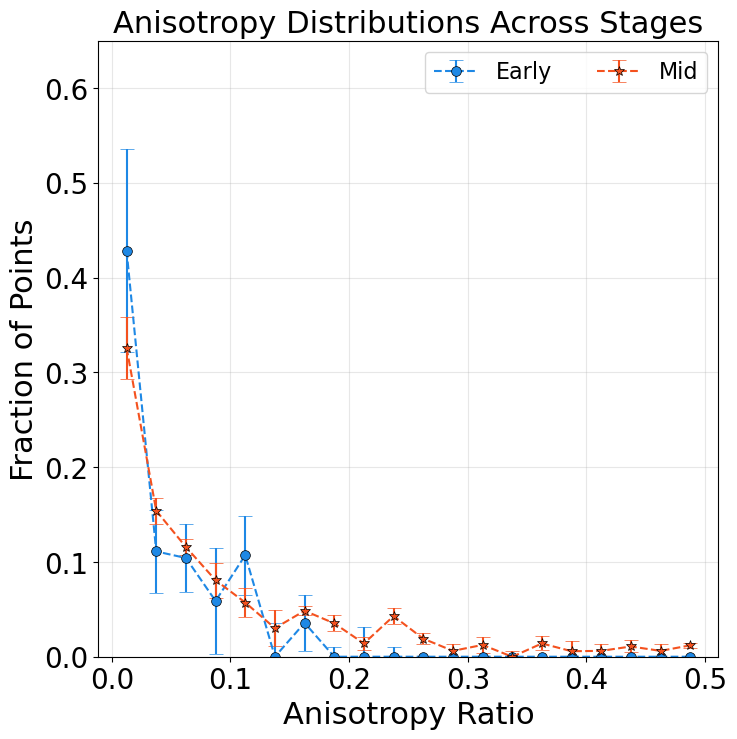

In [9]:
def plot_combined_anisotropy_distributions(stage_files, stage_labels, num_bins=20):
    """
    Plots the anisotropy distribution with error bars (0.5 * IQR) 
    for multiple stages on the same plot, with bins constrained to [0, 0.5].

    Parameters:
        stage_files (list of str): List of CSV file paths, one per stage.
        stage_labels (list of str): Labels for the stages.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 8))

    # Define colors, markers, and dataset labels
    color_labels = ['#1E88E5', '#F4511E']  # Colors for Early, Middle stages
    marker_labels = ["o", "*"]  # Markers for Early, Middle stages

    # Define fixed bin edges between 0 and 0.5
    bin_edges = np.linspace(0, 0.5, num_bins + 1)

    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        # Load anisotropy data
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        # List to store histograms (raw counts)
        histograms = []

        # Group by 'file_address'
        for _, group in df.groupby('file_address'):
            # Extract anisotropy values and remove NaNs
            anisotropy_values = group['anisotropy_ratio'].dropna().values

            # Calculate the histogram (raw counts, no density)
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)  # Raw counts histogram

            # Calculate fraction by dividing by the total number of points
            hist_fraction = hist / hist.sum()  # Fraction for each bin
            histograms.append(hist_fraction)

        # Convert histograms to a NumPy array for further processing
        histograms = np.array(histograms)  # Shape will be (num_movies, num_bins)

        # Compute median and 0.5 * IQR for each bin
        median_hist = np.median(histograms, axis=0)
        iqr_hist = np.percentile(histograms, 75, axis=0) - np.percentile(histograms, 25, axis=0)
        error_bars = 0.5 * iqr_hist

        # Compute bin centers for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot with dashed lines and error bars
        plt.errorbar(bin_centers, median_hist, yerr=error_bars, fmt=marker_labels[i], color=color_labels[i], 
                     capsize=5, linestyle='--', label=label, markeredgecolor='black', 
                     markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)

    # Labels and formatting
    plt.xlabel("Anisotropy Ratio", fontsize=22)
    plt.ylabel("Fraction of Points", fontsize=22)
    plt.title("Anisotropy Distributions Across Stages", fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=16, ncol=2)
    plt.ylim([0,0.65])
    plt.grid(alpha=0.3)
    
    # plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Ridges\\minimum_8_frames\\ridge_orientation_of_tracks.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_turning_metrics.csv"
]
stage_labels = ["Early", "Mid", "Late"]

plot_combined_anisotropy_distributions(stage_files, stage_labels)


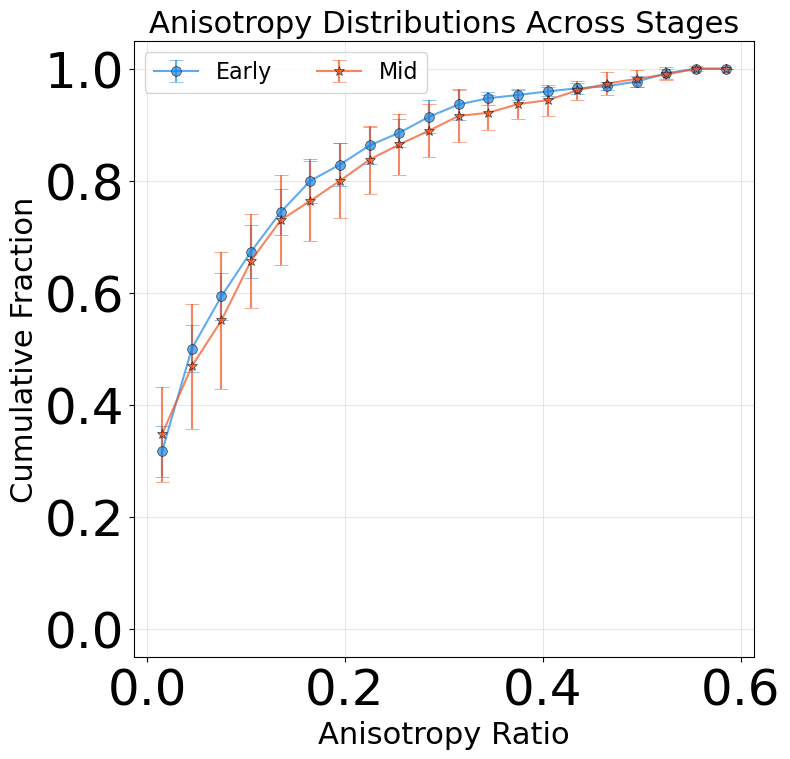

In [141]:
def plot_anisotropy_distributions(stage_files, stage_labels, num_bins=20):
    """
    Plots the anisotropy distribution with error bars (0.5 * IQR) 
    and the cumulative distribution for multiple stages on the same plot.
    """
    plt.figure(figsize=(8, 8))

    color_labels = ['#1E88E5', '#F4511E']  # Colors for Early, Middle, Late stages
    marker_labels = ["o", "*"]  # Markers for Early, Middle, Late stages

    bin_edges = np.linspace(0, 0.6, num_bins + 1)

    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        df = pd.read_csv(file_path)
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        histograms = []
        cumulative_histograms = []

        for _, group in df.groupby('file_address'):
            anisotropy_values = group['anisotropy_ratio'].dropna().values
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)
            hist_fraction = hist / hist.sum()
            histograms.append(hist_fraction)
            cumulative_histograms.append(np.cumsum(hist_fraction))

        histograms = np.array(histograms)
        cumulative_histograms = np.array(cumulative_histograms)

        median_cdf = np.median(cumulative_histograms, axis=0)
        iqr_cdf = np.percentile(cumulative_histograms, 75, axis=0) - np.percentile(cumulative_histograms, 25, axis=0)
        error_cdf = 0.5 * iqr_cdf

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        
        plt.errorbar(bin_centers, median_cdf, yerr=error_cdf, fmt=marker_labels[i], color=color_labels[i],
                     capsize=5, linestyle='-', label=f"{label}", markeredgecolor='black',
                     markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=0.7)
    
    plt.xlabel("Anisotropy Ratio", fontsize=22)
    plt.ylabel("Cumulative Fraction", fontsize=22)
    plt.title("Anisotropy Distributions Across Stages", fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=36)
    plt.tick_params(axis='both', which='minor', labelsize=36)
    plt.legend(fontsize=16, ncol=2)
    plt.grid(alpha=0.3)
    plt.ylim([-0.05,1.05])
    plt.savefig(data_folder+'\\ridge_orientation_of_tracks_cumulative.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv",
    r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_turning_metrics.csv",
]
stage_labels = ["Early", "Mid"]

data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames')
plot_anisotropy_distributions(stage_files, stage_labels)


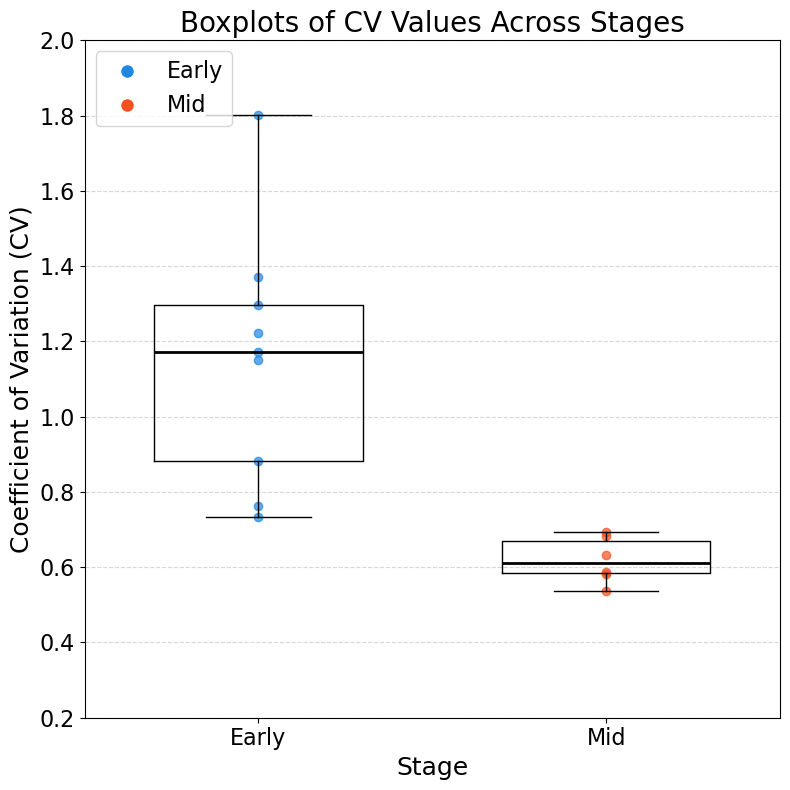

In [191]:
def plot_cv_boxplots(stage_files, stage_labels):
    """
    Plots boxplots for the Coefficient of Variation (CV) values for multiple stages,
    with scatter points for each CV value.
    
    Parameters:
        stage_files (list of str): List of CSV file paths, one per stage.
        stage_labels (list of str): Labels for the stages.
    """
    # Prepare data for plotting boxplots
    cv_values = []

    for file_path in stage_files:
        # Load the CV data for the stage
        df = pd.read_csv(file_path)
        
        # Ensure that the file contains the 'CV' column
        if 'CV' not in df.columns:
            raise ValueError("The file must contain a 'CV' column.")
        
        # Extract the CV values and append them
        cv_values.append(df['CV'].values)

    # Define colors and markers
    color_labels = ['#1E88E5', '#F4511E']  # Colors for Early, Middle, Late stages

    # Create the boxplot without fill
    plt.figure(figsize=(8, 8))

    # Create the boxplot (no fill color for boxes)
    box = plt.boxplot(cv_values, patch_artist=False, medianprops=dict(color="black", linewidth=2), 
                      widths=0.6, vert=True)

    # Set the y-axis limits (you can adjust these based on your data)
    plt.ylim([0.2, 2.0])  # Example limit, adjust based on your data range

    # Scatter the CV values over the boxplot
    for i, cv in enumerate(cv_values):
        plt.scatter([i + 1] * len(cv), cv, color=color_labels[i], alpha=0.7, marker="o")

    # Set titles and labels
    plt.xticks(np.arange(1, len(stage_labels) + 1), stage_labels, fontsize=16)
    plt.xlabel("Stage", fontsize=18)
    plt.ylabel("Coefficient of Variation (CV)", fontsize=18)
    plt.title("Boxplots of CV Values Across Stages", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Create a legend for scatter points (using Line2D to represent each scatter point)
    handles = []
    for i, color in enumerate(color_labels):
        # Create a dummy legend entry for each stage
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    plt.legend(handles=handles, labels=stage_labels, loc='upper left', fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
stage_files = [
    r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_cv.csv",
    r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_cv.csv",
]
stage_labels = ["Early", "Mid"]

# Plot CV boxplots with scatter points
plot_cv_boxplots(stage_files, stage_labels)


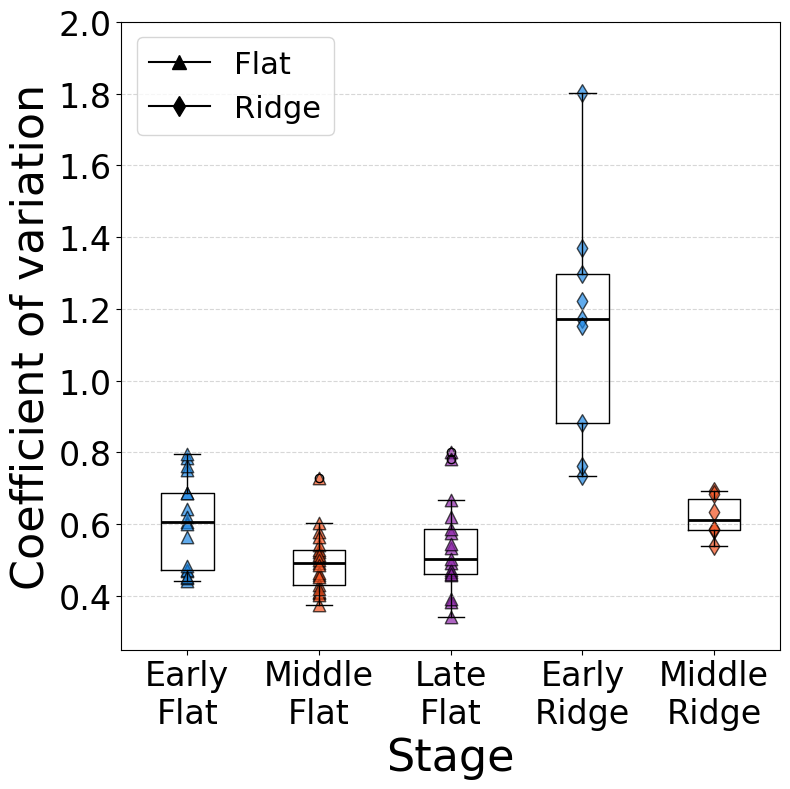

In [24]:
def plot_combined_cv_boxplots(stage_files, stage_labels, group_labels):
    """
    Plots combined boxplots for the Coefficient of Variation (CV) values for multiple stages,
    with scatter points for each CV value, grouped by surface type (flat or ridged).
    
    Parameters:
        stage_files (list of list of str): List of CSV file paths for each stage.
        stage_labels (list of str): Labels for the stages.
        group_labels (list of str): Labels for each group of stages, e.g., ["Flat Surface", "Ridged Surface"]
    """
    # Prepare data for plotting boxplots
    cv_values = []
    group_colors = ['#1E88E5', '#F4511E', '#8E24AA', '#1E88E5', '#F4511E']  # Colors for different stages

    # Iterate through the stage files and group them accordingly
    for file_paths in stage_files:
        stage_cv_values = []
        for file_path in file_paths:
            # Load the CV data for the stage
            df = pd.read_csv(file_path)
            
            # Ensure that the file contains the 'CV' column
            if 'CV' not in df.columns:
                raise ValueError("The file must contain a 'CV' column.")
            
            # Extract the CV values and append them
            stage_cv_values.append(df['CV'].values)
        
        # Flatten the list of CV values for the current stage
        cv_values.append(np.concatenate(stage_cv_values))

    # Define colors and markers for different stages
    plt.figure(figsize=(8, 8))
    
    # Create the boxplot with narrower boxes and closer spacing between them
    box = plt.boxplot(cv_values, patch_artist=False, medianprops=dict(color="black", linewidth=2),
                      widths=0.4, vert=True, positions=np.arange(1, len(stage_labels) + 1))

    # Set the y-axis limits (you can adjust these based on your data)
    plt.ylim([0.0, 2.0])  # Example limit, adjust based on your data range


    # Scatter the CV values over the boxplot with different markers and black outlines
    # Define different markers for flat and ridged surfaces
    flat_markers = ["^", "^", "^"]  # Circle, Star, Diamond for flat surface
    ridges_markers = ["d", "d"]  # Square, Pentagon, Triangle for ridged surface
    
    # Scatter the CV values over the boxplot with different markers and black outlines
    for i, cv in enumerate(cv_values):
        if i < 3:  # Assuming the first 3 stages are for the flat surface
            marker = flat_markers[i]  # Use the flat surface markers
        else:  # Assuming the next 2 stages are for the ridged surface
            marker = ridges_markers[i - 3]  # Use the ridged surface markers
    
        plt.scatter([i + 1] * len(cv), cv, 80, color=group_colors[i], alpha=0.7, marker=marker, edgecolor='black', linewidth=1)



    # Set titles and labels
    plt.xticks(np.arange(1, len(stage_labels) + 1), stage_labels, fontsize=24)
    plt.xlabel("Stage", fontsize=32)
    plt.ylim([0.25,2.0])
    plt.ylabel("Coefficient of variation", fontsize=32)
    # plt.title("CV Values for new tracks Across Stages (Flat vs Ridged Surface)", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Create a legend for scatter points (using Line2D to represent each scatter point)
    # handles = []
    # for i, color in enumerate(group_colors):
    #     # Create a dummy legend entry for each stage
    #     handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    # plt.legend(handles=handles, labels=group_labels, loc='upper left', fontsize=16)

    import matplotlib.lines as mlines


    # Define your custom markers for the legend
    flat_marker = mlines.Line2D([], [], color='black', marker='^', markersize=10, label='Flat Surface')
    ridges_marker = mlines.Line2D([], [], color='black', marker='d', markersize=10, label='Ridges Surface')
    
    # Add the custom markers to the legend
    handles = [flat_marker, ridges_marker]
    plt.legend(handles=handles, labels=['Flat', 'Ridge'], loc='upper left', fontsize=22)


    # Show the plot
    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Combined Plots_glass_vs_ridge\\flat_vs_ridge_new_tracks_CV.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage:
stage_files = [
    # Flat Surface Stages (3 stages)
    [
        r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_cv.csv"
    ],
    [
        r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_cv.csv"
    ],
    [
        r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_cv.csv"
    ],
    # Ridged Surface Stages (2 stages)
    [
        r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_cv.csv"
    ],
    [
        r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_cv.csv"
    ]
]

# Define the stage labels with a line break between "Flat" and "Ridged"
stage_labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]
# plt.xticks(ticks=range(len(stage_labels)), labels=stage_labels)


group_labels = ["Flat", "Ridge"]

# Plot combined CV boxplots with scatter points for grouped surfaces
plot_combined_cv_boxplots(stage_files, stage_labels, group_labels)


In [12]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def test_cv_from_csvs(stage_files, stage_labels, output_path="cv_stats.csv"):
    """
    Loads Coefficient of Variation (CV) values from CSVs, tests for normality, and performs
    statistical comparisons using:
    - Shapiro–Wilk normality tests
    - ANOVA + Tukey HSD for Flat intra-group comparisons (if normal and significant)
    - Kruskal–Wallis for non-normal group data
    - T-tests or Mann–Whitney U for Flat vs Ridge and Ridge intra-group comparisons

    Results are printed and saved to a CSV file.

    Parameters:
    -----------
    stage_files : list of list of str
        Each sublist contains paths to CSV files representing one experimental stage.

    stage_labels : list of str
        Descriptive labels for each stage (e.g., "Early\nFlat").

    output_path : str
        Path to save the resulting summary table.
    """
    results = []
    cv_values = []

    # ----------------------------------
    # Load CV values from CSVs
    # ----------------------------------
    for group in stage_files:
        stage_vals = []
        for csv_file in group:
            df = pd.read_csv(csv_file)
            if 'CV' not in df.columns:
                raise ValueError(f"{csv_file} must contain a 'CV' column.")
            stage_vals.extend(df['CV'].dropna().values)
        cv_values.append(np.array(stage_vals))

    # ----------------------------------
    # Shapiro–Wilk Normality Test
    # ----------------------------------
    normality_results = []
    for i, vals in enumerate(cv_values):
        stat, p = shapiro(vals)
        normality_results.append(p)
        normality_label = 'Normal' if p >= 0.05 else 'Non-normal'
        print(f"Shapiro–Wilk for {stage_labels[i]}: p = {p:.3g} → {normality_label}")
        results.append({
            'Comparison': f"Shapiro–Wilk: {stage_labels[i]}",
            'Test': 'Shapiro–Wilk',
            'Stat': stat,
            'p-value': p,
            'Significance': normality_label
        })

    any_non_normal = any(p < 0.05 for p in normality_results)
    print(f"\nUsing {'non-parametric' if any_non_normal else 'parametric'} tests.\n")

    # ----------------------------------
    # Flat vs Ridge comparisons (Early & Middle)
    # ----------------------------------
    for i in range(2):  # Compare Early and Middle stages only
        flat = cv_values[i]
        ridge = cv_values[i + 3]
        stage = stage_labels[i].split('\n')[0]
        if any_non_normal:
            stat, p = mannwhitneyu(flat, ridge, alternative='two-sided')
            test_name = "Mann–Whitney U"
        else:
            stat, p = ttest_ind(flat, ridge, equal_var=False)
            test_name = "T-test"
        print(f"{test_name} for {stage} stage (Flat vs Ridge): stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': f"{stage} Flat vs Ridge",
            'Test': test_name,
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })

    # ----------------------------------
    # FLAT intra-group comparison (Early vs Middle vs Late)
    # ----------------------------------
    flat_vals = cv_values[:3]
    flat_labels = stage_labels[:3]
    flat_concat = np.concatenate(flat_vals)
    flat_stage_names = np.concatenate([[label] * len(vals) for label, vals in zip(flat_labels, flat_vals)])

    if any_non_normal:
        stat, p = kruskal(*flat_vals)
        test_name = "Kruskal–Wallis"
        print(f"{test_name} across Flat stages: stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': 'Flat: Early vs Middle vs Late',
            'Test': test_name,
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })
    else:
        stat, p = f_oneway(*flat_vals)
        print(f"ANOVA across Flat stages: stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': 'Flat: Early vs Middle vs Late',
            'Test': 'ANOVA',
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })

        # Run Tukey HSD if significant
        if p < 0.05:
            print("→ Running Tukey’s HSD post-hoc test for Flat:")
            tukey_result = pairwise_tukeyhsd(flat_concat, flat_stage_names, alpha=0.05)
            print(tukey_result)
            tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
            tukey_df.insert(0, 'Comparison', 'Tukey HSD (Flat)')
            tukey_df.to_csv(output_path.replace('.csv', '_tukey.csv'), index=False, encoding='utf-8-sig')

    # ----------------------------------
    # RIDGED intra-group: Early vs Middle
    # ----------------------------------
    ridge_early = cv_values[3]
    ridge_middle = cv_values[4]

    if any_non_normal:
        stat, p = mannwhitneyu(ridge_early, ridge_middle, alternative='two-sided')
        test_name = "Mann–Whitney U"
    else:
        stat, p = ttest_ind(ridge_early, ridge_middle, equal_var=False)
        test_name = "T-test"

    print(f"{test_name} for Early vs Middle (Ridges): stat = {stat:.3f}, p = {p:.3g}")
    results.append({
        'Comparison': 'Ridges: Early vs Middle',
        'Test': test_name,
        'Stat': stat,
        'p-value': p,
        'Significance': 'Yes' if p < 0.05 else 'No'
    })

    # ----------------------------------
    # Save all summary results
    # ----------------------------------
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n✅ Results saved to: {output_path}")


In [14]:
stage_files = [
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_cv.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_cv.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_cv.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_cv.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_cv.csv"]
]

stage_labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]

test_cv_from_csvs(stage_files, stage_labels,
    output_path=r"E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge\cv_stats.csv")

Shapiro–Wilk for Early
Flat: p = 0.0785 → Normal
Shapiro–Wilk for Middle
Flat: p = 0.181 → Normal
Shapiro–Wilk for Late
Flat: p = 0.343 → Normal
Shapiro–Wilk for Early
Ridge: p = 0.526 → Normal
Shapiro–Wilk for Middle
Ridge: p = 0.598 → Normal

Using parametric tests.

T-test for Early stage (Flat vs Ridge): stat = -4.758, p = 0.000962
T-test for Middle stage (Flat vs Ridge): stat = -4.081, p = 0.0019
ANOVA across Flat stages: stat = 4.530, p = 0.0154
→ Running Tukey’s HSD post-hoc test for Flat:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1      group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
Early
Flat   Late
Flat  -0.0702 0.1725 -0.1631  0.0228  False
Early
Flat Middle
Flat  -0.1098 0.0115 -0.1982 -0.0214   True
 Late
Flat Middle
Flat  -0.0396 0.5304  -0.128  0.0488  False
-------------------------------------------------------------
T-test for Early vs Middle (Ridges): stat = 4.679, p = 0.00123



In [15]:
## Old testing

In [202]:
# Perform t-tests within groups (Flat vs Ridged for the same stage)
for i in range(3):  # Flat stages are indices 0, 1, 2; Ridged stages are 3, 4
    if i < 2:  # Ensure there's a matching stage in Ridged
        t_stat, p_value = ttest_ind(cv_values[i], cv_values[i + 3], equal_var=False)
        print(f"T-test for {stage_labels[i]} stage (Flat vs Ridged): t = {t_stat:.3f}, p = {p_value:.3g}")

    # Additional comparison: Early (0) vs Late (2) for Flat
    if i == 0:  # Early stage (Flat) comparison
        t_stat, p_value = ttest_ind(cv_values[0], cv_values[2], equal_var=False)
        print(f"T-test for Early (Flat) vs Late (Flat) stage: t = {t_stat:.3f}, p = {p_value:.3g}")

# Perform t-tests between stages within the same surface
for i in range(len(cv_values) - 1):
    if (i < 2 and i + 1 < 3):  # Flat stages (0-2)
        t_stat, p_value = ttest_ind(cv_values[i], cv_values[i + 1], equal_var=False)
        print(f"T-test between {stage_labels[i]} and {stage_labels[i + 1]} (Flat group): t = {t_stat:.3f}, p = {p_value:.3g}")
    elif (i >= 3 and i + 1 < 5):  # Ridged stages (3-4)
        t_stat, p_value = ttest_ind(cv_values[i], cv_values[i + 1], equal_var=False)
        print(f"T-test between {stage_labels[i]} and {stage_labels[i + 1]} (Ridged group): t = {t_stat:.3f}, p = {p_value:.3g}")


T-test for Early stage (Flat vs Ridged): t = -4.758, p = 0.000962
T-test for Early (Flat) vs Late (Flat) stage: t = 1.604, p = 0.119
T-test for Middle stage (Flat vs Ridged): t = -4.081, p = 0.0019
T-test between Early and Middle (Flat group): t = 3.087, p = 0.00472
T-test between Middle and Late (Flat group): t = -1.101, p = 0.281
T-test between Early and Middle (Ridged group): t = 4.679, p = 0.00123


## Flat vs Ridge anisotropy comparison (Early)

Wasserstein Distance-1 (Flat vs Ridge): 0.023554
Plot saved to E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge/early_flat_vs_ridge_anisotropy_non_cumulative.svg


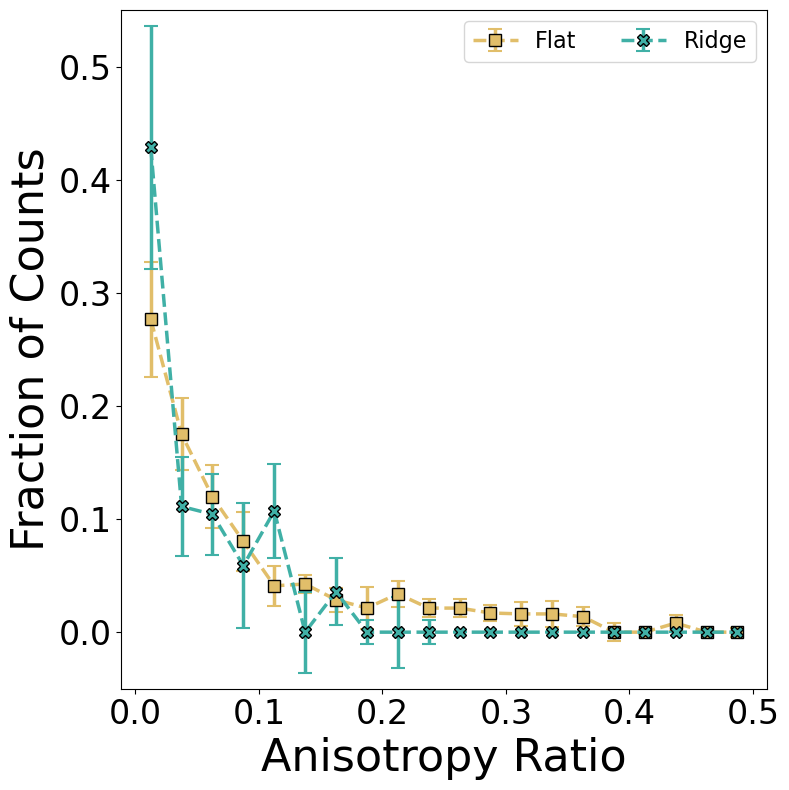

In [72]:
def plot_flat_vs_ridge_stage(flat_stage_file, ridge_stage_file, flat_label="Flat", ridge_label="Ridge", num_bins=20, transparency=0.6, data_folder=None, save_name=None):
    """
    Plots the anisotropy distribution for the early stage on flat and ridge surfaces.

    Parameters:
        flat_stage_file (str): CSV file path for the flat surface early stage.
        ridge_stage_file (str): CSV file path for the ridge surface early stage.
        flat_label (str): Label for the flat surface.
        ridge_label (str): Label for the ridge surface.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 8))

    # Define colors and markers for flat and ridge
    color_labels = ['#E1BE6A', '#40B0A6']  # Colors for Flat and Ridge
    marker_labels = ["s", "X"]  # Markers for Flat and Ridge

    # Define fixed bin edges between 0 and 0.5
    bin_edges = np.linspace(0, 0.5, num_bins + 1)

    # List of files and corresponding labels
    stage_files = [flat_stage_file, ridge_stage_file]
    stage_labels = [flat_label, ridge_label]

    median_hist_arr = []
    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        # Load anisotropy data
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        # List to store histograms (raw counts)
        histograms = []

        # Group by 'file_address'
        for _, group in df.groupby('file_address'):
            # Extract anisotropy values and remove NaNs
            anisotropy_values = group['anisotropy_ratio'].dropna().values

            # Calculate the histogram (raw counts, no density)
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)  # Raw counts histogram

            # Calculate fraction by dividing by the total number of points
            hist_fraction = hist / hist.sum()  # Fraction for each bin
            histograms.append(hist_fraction)

        # Convert histograms to a NumPy array for further processing
        histograms = np.array(histograms)  # Shape will be (num_movies, num_bins)

        # Compute median and 0.5 * IQR for each bin
        median_hist = np.median(histograms, axis=0)
        iqr_hist = np.percentile(histograms, 75, axis=0) - np.percentile(histograms, 25, axis=0)
        error_bars = 0.5 * iqr_hist

        # Compute bin centers for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot with dashed lines and error bars
        plt.errorbar(bin_centers, median_hist, yerr=error_bars, fmt=marker_labels[i], color=color_labels[i], 
                     linestyle='--', label=label, markeredgecolor='black', 
                     capsize=5, capthick=1.5, markersize=9, linewidth=2.5, alpha=transparency)
        median_hist_arr.append(median_hist)

    # Labels and formatting
    plt.xlabel("Anisotropy Ratio", fontsize=32)
    plt.ylabel("Fraction of Counts", fontsize=32)
    # plt.title("Anisotropy Distribution (Early Stage): Flat vs Ridge", fontsize=22)
    plt.ylim([-0.05, 0.55])
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.tick_params(axis='both', which='minor', labelsize=24)
    plt.legend(fontsize=16, ncol=2)
    # plt.grid(alpha=0.3)

    print(f"Wasserstein Distance-1 (Flat vs Ridge): {wasserstein_distance(median_hist_arr[0], median_hist_arr[1], p=1):.6f}")  

    # Save or show the plot
    plt.tight_layout()
    if data_folder and save_name:
        save_path = f"{data_folder}/{save_name}.svg"
        plt.savefig(save_path, format='svg')
        print(f"Plot saved to {save_path}")
    plt.show()

# Example usage:
flat_stage_file = r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv"
ridge_stage_file = r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_turning_metrics.csv"
data_folder=r"E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge"


plot_flat_vs_ridge_stage(flat_stage_file, ridge_stage_file,transparency=1.0,data_folder=data_folder,save_name='early_flat_vs_ridge_anisotropy_non_cumulative')


Plot saved to E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge/early_flat_vs_ridge_anisotropy_cumulative.svg


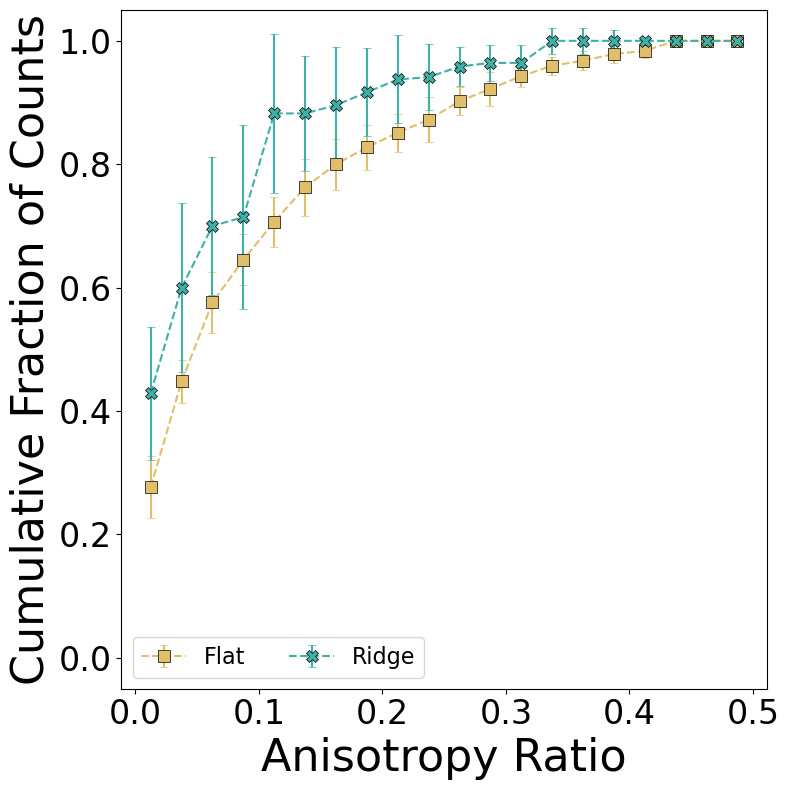

In [73]:
def plot_flat_vs_ridge_stage_cumulative(flat_stage_file, ridge_stage_file, flat_label="Flat", ridge_label="Ridge", num_bins=20, transparency=0.6, data_folder=None, save_name=None):
    """
    Plots the anisotropy distribution for the early stage on flat and ridge surfaces with cumulative fractions.

    Parameters:
        flat_stage_file (str): CSV file path for the flat surface early stage.
        ridge_stage_file (str): CSV file path for the ridge surface early stage.
        flat_label (str): Label for the flat surface.
        ridge_label (str): Label for the ridge surface.
        num_bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 8))

    # Define colors and markers for flat and ridge
    color_labels = ['#E1BE6A', '#40B0A6']  # Colors for Flat and Ridge
    marker_labels = ["s", "X"]  # Markers for Flat and Ridge

    # Define fixed bin edges between 0 and 0.5
    bin_edges = np.linspace(0, 0.5, num_bins + 1)

    # List of files and corresponding labels
    stage_files = [flat_stage_file, ridge_stage_file]
    stage_labels = [flat_label, ridge_label]

    median_hist_arr = []
    for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
        # Load anisotropy data
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
            raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

        # List to store histograms (raw counts)
        histograms = []

        # Group by 'file_address'
        for _, group in df.groupby('file_address'):
            # Extract anisotropy values and remove NaNs
            anisotropy_values = group['anisotropy_ratio'].dropna().values

            # Calculate the histogram (raw counts, no density)
            hist, _ = np.histogram(anisotropy_values, bins=bin_edges)  # Raw counts histogram

            # Calculate cumulative fraction by dividing the cumulative sum by the total count
            cumulative_hist = np.cumsum(hist)  # Cumulative sum of counts
            cumulative_hist_fraction = cumulative_hist / cumulative_hist[-1] if cumulative_hist[-1] != 0 else cumulative_hist
            histograms.append(cumulative_hist_fraction)

        # Convert histograms to a NumPy array for further processing
        histograms = np.array(histograms)  # Shape will be (num_movies, num_bins)

        # Compute median and IQR for the cumulative histograms at each bin
        cumulative_hist_median = np.median(histograms, axis=0)
        iqr_hist = np.percentile(histograms, 75, axis=0) - np.percentile(histograms, 25, axis=0)
        error_bars = 0.5 * iqr_hist

        # Compute bin centers for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot with dashed lines and error bars
        plt.errorbar(bin_centers, cumulative_hist_median, yerr=error_bars, fmt=marker_labels[i], color=color_labels[i], 
                     linestyle='--', label=label, markeredgecolor='black', markeredgewidth=0.5,
                     capsize=3, capthick=0.5, markersize=9, linewidth=1.5, alpha=transparency)
        median_hist_arr.append(cumulative_hist_median)

    # Labels and formatting
    plt.xlabel("Anisotropy Ratio", fontsize=32)
    plt.ylabel("Cumulative Fraction of Counts", fontsize=32)
    plt.ylim([-0.05, 1.05])
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.tick_params(axis='both', which='minor', labelsize=24)
    plt.legend(fontsize=16, ncol=2)

    # Save or show the plot
    plt.tight_layout()
    if data_folder and save_name:
        save_path = f"{data_folder}/{save_name}.svg"
        plt.savefig(save_path, format='svg')
        print(f"Plot saved to {save_path}")
    plt.show()

# Example usage:
flat_stage_file = r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv"
ridge_stage_file = r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_turning_metrics.csv"
data_folder = r"E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge"

plot_flat_vs_ridge_stage_cumulative(flat_stage_file, ridge_stage_file, transparency=1.0, data_folder=data_folder, save_name='early_flat_vs_ridge_anisotropy_cumulative')

## Flat vs Ridge anisotropy comparison (Middle)

Wasserstein Distance-1 (Flat vs Ridge): 0.005846
Plot saved to E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge/middle_flat_vs_ridge_anisotropy_non_cumulative.svg


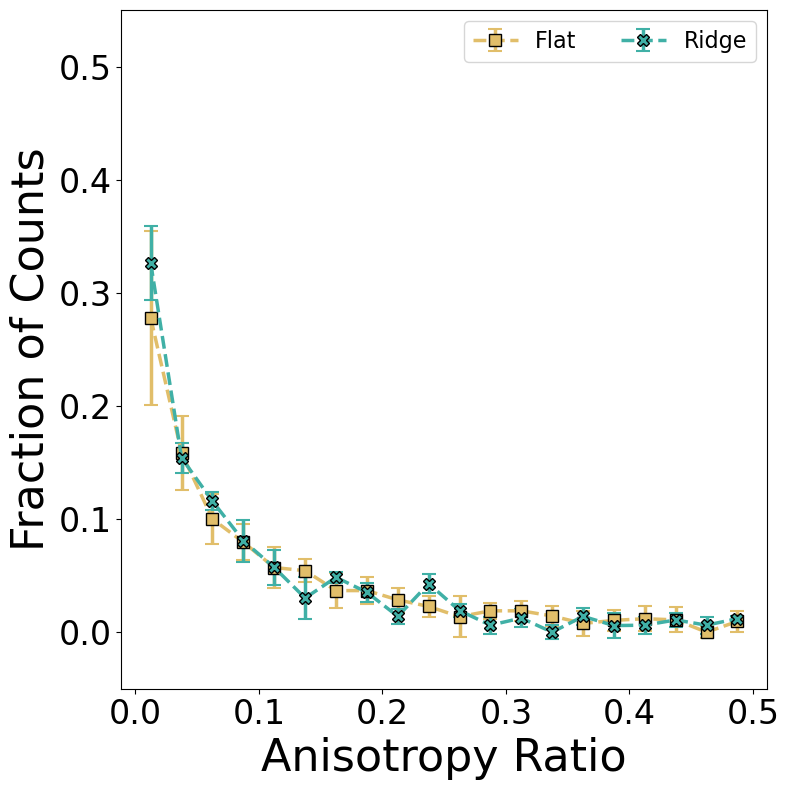

In [74]:
flat_stage_file = r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_turning_metrics.csv"
ridge_stage_file = r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_turning_metrics.csv"
plot_flat_vs_ridge_stage(flat_stage_file, ridge_stage_file,transparency=1.0,data_folder=data_folder,save_name='middle_flat_vs_ridge_anisotropy_non_cumulative')


Plot saved to E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge/early_flat_vs_ridge_anisotropy_cumulative.svg


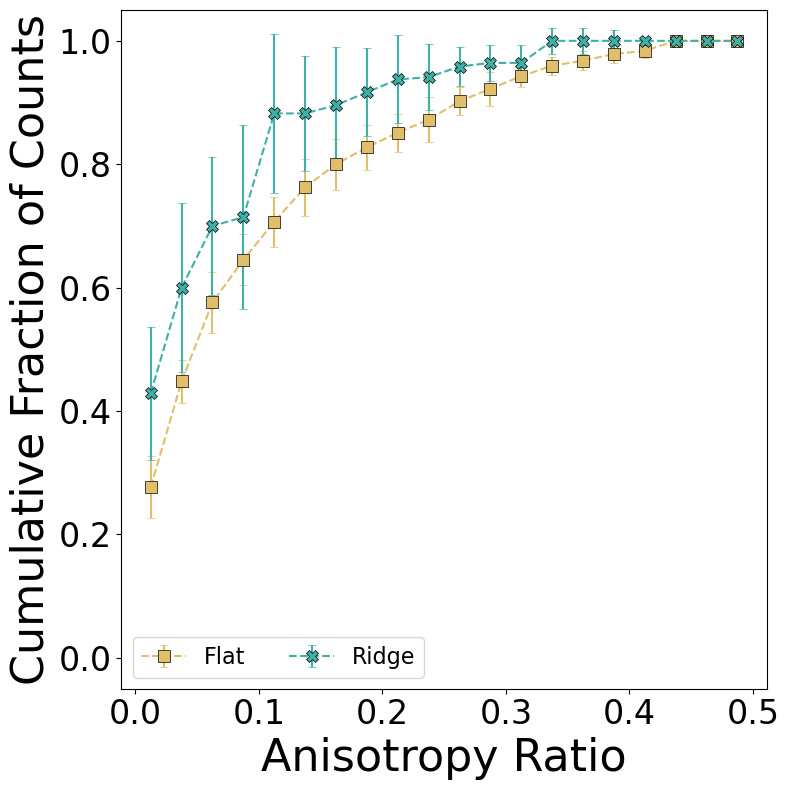

In [75]:
# def plot_flat_vs_ridge_stage_cumulative(flat_stage_file, ridge_stage_file, flat_label="Flat", ridge_label="Ridge", num_bins=20, transparency=0.6, data_folder=None, save_name=None):
#     """
#     Plots the cumulative anisotropy distribution for the early stage on flat and ridge surfaces.

#     Parameters:
#         flat_stage_file (str): CSV file path for the flat surface early stage.
#         ridge_stage_file (str): CSV file path for the ridge surface early stage.
#         flat_label (str): Label for the flat surface.
#         ridge_label (str): Label for the ridge surface.
#         num_bins (int): Number of bins for the histogram.
#         transparency (float): Transparency of the plot.
#         data_folder (str, optional): Folder to save the plot.
#         save_name (str, optional): Name to save the plot as.
#     """
#     plt.figure(figsize=(8, 8))

#     # Define colors and markers for flat and ridge
#     color_labels = ['#E1BE6A', '#40B0A6']  # Colors for Flat and Ridge
#     marker_labels = ["s", "X"]  # Markers for Flat and Ridge

#     # Define fixed bin edges between 0 and 0.5
#     bin_edges = np.linspace(0, 0.5, num_bins + 1)

#     # List of files and corresponding labels
#     stage_files = [flat_stage_file, ridge_stage_file]
#     stage_labels = [flat_label, ridge_label]

#     for i, (file_path, label) in enumerate(zip(stage_files, stage_labels)):
#         # Load anisotropy data
#         df = pd.read_csv(file_path)

#         # Ensure required columns exist
#         if 'file_address' not in df.columns or 'anisotropy_ratio' not in df.columns:
#             raise ValueError("The file must contain 'file_address' and 'anisotropy_ratio' columns.")

#         # List to store histograms (raw counts)
#         histograms = []

#         # Group by 'file_address'
#         for _, group in df.groupby('file_address'):
#             # Extract anisotropy values and remove NaNs
#             anisotropy_values = group['anisotropy_ratio'].dropna().values

#             # Calculate the histogram (raw counts, no density)
#             hist, _ = np.histogram(anisotropy_values, bins=bin_edges)  # Raw counts histogram

#             # Calculate fraction by dividing by the total number of points
#             hist_fraction = hist / hist.sum()  # Fraction for each bin
#             histograms.append(hist_fraction)

#         # Convert histograms to a NumPy array for further processing
#         histograms = np.array(histograms)  # Shape will be (num_movies, num_bins)

#         # Compute cumulative distribution by summing the fractions
#         cumulative_hist = np.cumsum(np.median(histograms, axis=0))
#         cumulative_hist /= cumulative_hist[-1]  # Normalize to get a proper cumulative distribution

#         # Compute bin centers for plotting
#         bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#         # Plot with dashed lines and error bars
#         plt.plot(bin_centers, cumulative_hist, marker=marker_labels[i], color=color_labels[i], 
#                  linestyle='--', label=label, markeredgecolor='black', 
#                  markersize=9, linewidth=1.5, markeredgewidth=0.5, alpha=transparency)

#     # Labels and formatting
#     plt.xlabel("Anisotropy Ratio", fontsize=32)
#     plt.ylabel("Cumulative Fraction", fontsize=32)
#     plt.title("Cumulative Anisotropy Distribution (Early Stage): Flat vs Ridge", fontsize=22)
#     plt.ylim([0, 1.05])
#     plt.tick_params(axis='both', which='major', labelsize=24)
#     plt.tick_params(axis='both', which='minor', labelsize=24)
#     plt.legend(fontsize=16, ncol=2)
#     plt.grid(alpha=0.3)

#     # Save or show the plot
#     plt.tight_layout()
#     if data_folder and save_name:
#         save_path = f"{data_folder}/{save_name}.svg"
#         plt.savefig(save_path, format='svg')
#         print(f"Plot saved to {save_path}")
#     plt.show()

# Example usage:
flat_stage_file = r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_turning_metrics.csv"
ridge_stage_file = r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_turning_metrics.csv"
data_folder='E:\\Spandan\\2D_Neurons_Paper\\Combined Plots_glass_vs_ridge'

plot_flat_vs_ridge_stage_cumulative(flat_stage_file, ridge_stage_file, transparency=1.0, data_folder=data_folder, save_name='early_flat_vs_ridge_anisotropy_cumulative')


Plot saved to E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge/middle_flat_vs_ridge_anisotropy_cumulative.svg


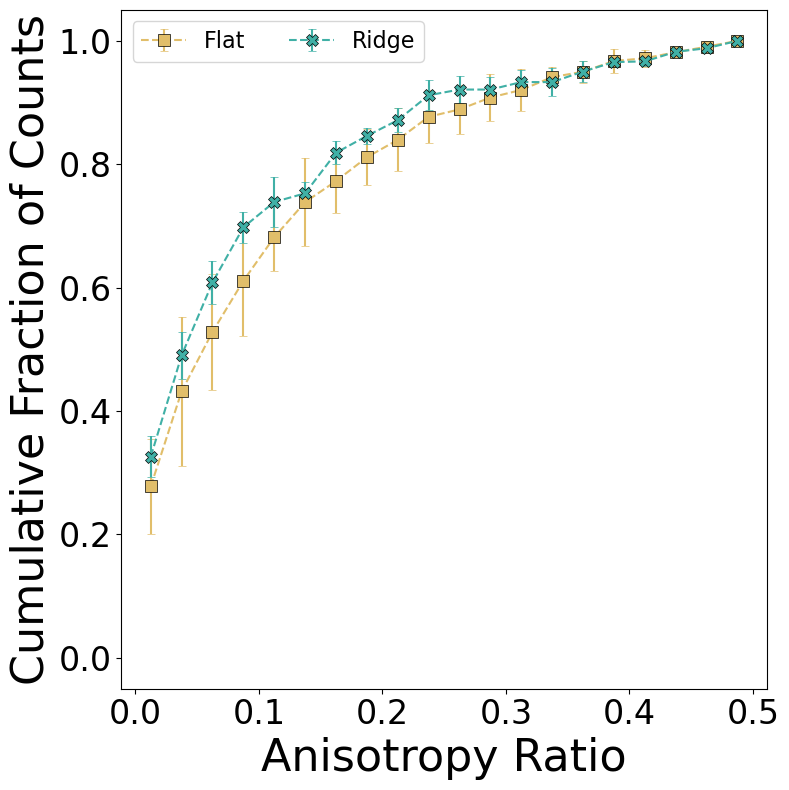

In [76]:
flat_stage_file = r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_turning_metrics.csv"
ridge_stage_file = r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_turning_metrics.csv"
plot_flat_vs_ridge_stage_cumulative(flat_stage_file, ridge_stage_file, transparency=1.0, data_folder=data_folder, save_name='middle_flat_vs_ridge_anisotropy_cumulative')